In [1]:
%matplotlib inline

In [2]:
from ssrs.raster import *
from ssrs import Terrain
from ssrs.layers import compute_thermals_3d, compute_adjusted_orographic_updraft

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

/home/rthedin/.conda-envs/ssrs_env/lib/python3.10/site-packages/herbie/archive.py:71: UserWarning: herbie xarray accessors could not be imported.You are probably missing the Carpenter_Workshop.If you want to use these functions, try`pip install git+https://github.com/blaylockbk/Carpenter_Workshop.git`
  warnings.warn(


# Example of thermal and orographic updraft computations

## 1. Get input information

In [3]:
# SW corner lat/lon
southwest_lonlat=(-106.21, 42.78)  # TOTW

# date in UTC. MST=UTC-7
time = (2021, 6, 14, 21, 0)

# grid parameters
extent = [0, 0, 50000, 50000]  # [xmin, ymin, xmax, xmax]
res = 50

height=150

## 2. Get the variables that would be available within `compute_thermals_3d` and `compute_adjusted_orographic_updraft` in SSRS

In [4]:
# longitude in degrees East (unusual; for GRIB)
min_lat = southwest_lonlat[1] -0.15
min_lon = 180-southwest_lonlat[0] -0.9
max_lat = min_lat + 0.7
max_lon = min_lon + 1.1

# longitude in degrees West (typical)
min_lon_degW = southwest_lonlat[0] -0.1
max_lon_degW = min_lon_degW + 0.8

# ger reference location
xSW, ySW = transform_coordinates('EPSG:4326','ESRI:102008', southwest_lonlat[0], southwest_lonlat[1])
xref = xSW[0]
yref = ySW[0]    
extentref = [extent[0]+xref, extent[1]+yref, extent[2]+xref, extent[3]+yref]

# Get terrain
terr = Terrain([min_lon_degW, min_lat, max_lon_degW,  max_lat], out_dir='tempTerrain')
terr.download(layers=['DEM','Aspect Degrees'])

Terrain: Bounds set to [-106.31, 42.63, -105.51, 43.33]
Terrain: Found saved raster data for DEM
Terrain: Found saved raster data for Aspect Degrees


In [5]:
# Create grid
x = np.arange(extent[0], extent[2], res)
y = np.arange(extent[1], extent[3], res)
xx, yy = np.meshgrid(x, y, indexing='ij')
nPointsx = int((extent[2]-extent[0])/res)
nPointsy = int((extent[3]-extent[1])/res)

# Get elevation map and aspect as done by SSRS
filedem = terr.get_raster_fpath('DEM')
elev = get_raster_in_projected_crs(filedem, extentref, (nPointsx, nPointsy), (res, res), 'ESRI:102008')

fileaspect = terr.get_raster_fpath('Aspect Degrees')
aspect = get_raster_in_projected_crs(fileaspect, extentref, (nPointsx, nPointsy), (res, res), 'ESRI:102008')


## 3. Thermal updrafts

In [6]:
wt = compute_thermals_3d(aspect, southwest_lonlat, extent, res, time, height, wfipInformed=True)

Using valid_date
🏋🏻‍♂️ Found 2021-Jun-14 21:00 UTC F00 [HRRR] [product=sfc] GRIB2 file from aws and index file from aws.                                                                                                                                                       
Note: Returning a list of [5] xarray.Datasets because of multiple hypercubes.
Creating 23318 thermals. The average boundary layer height is 566.776484


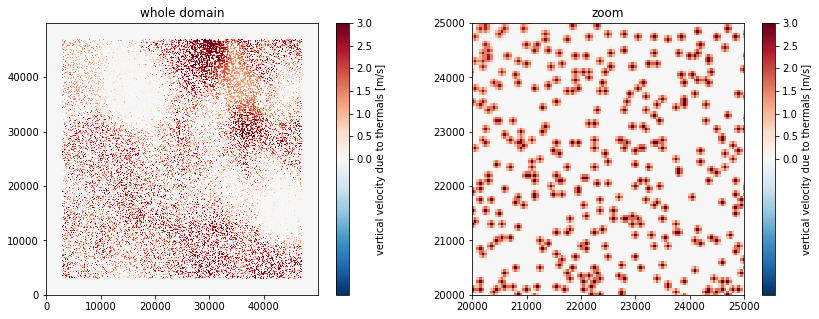

In [7]:
norm=colors.TwoSlopeNorm(vcenter=0, vmin=-0.1, vmax=3)

fig, axs = plt.subplots(ncols=2, figsize=(14,5))

cm = axs[0].pcolormesh(xx, yy, wt, shading='auto',  norm=norm, cmap='RdBu_r')
fig.colorbar(cm, ax=axs[0], label='vertical velocity due to thermals [m/s]')
axs[0].set_title('whole domain')

cm = axs[1].pcolormesh(xx, yy, wt, shading='auto',  norm=norm, cmap='RdBu_r')
fig.colorbar(cm, ax=axs[1], label='vertical velocity due to thermals [m/s]')
axs[1].set_title('zoom')
axs[1].set_xlim([20000, 25000])
axs[1].set_ylim([20000, 25000])

for ax in axs:
    ax.set_aspect('equal')
plt.show()

## 4. Orographic updrafts

In [8]:
wdir = 270        # 270 is W
wspdAt80m = 8
height = 80

In [9]:
w0adj, w0 = compute_adjusted_orographic_updraft(wspeedAtRefHeight = np.ones_like(xx)*wspdAt80m,
                                                wdirn = np.ones_like(xx)*wdir,
                                                elevation = elev,
                                                tc = 0.2, # WY terrain
                                                res = res,
                                                h = height,
                                                returnOriginal=True)

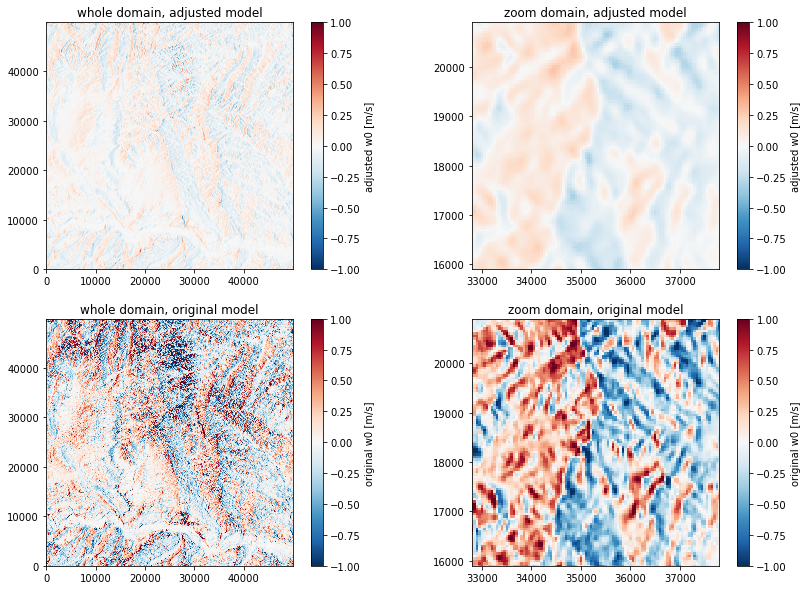

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(14,10))
axs=axs.flatten()

cm = axs[0].pcolormesh(xx, yy, np.transpose(w0adj), shading='auto', vmin=-1, vmax=1, cmap='RdBu_r')
fig.colorbar(cm, ax=axs[0], label='adjusted w0 [m/s]')
axs[0].set_title('whole domain, adjusted model')

cm = axs[1].pcolormesh(xx, yy, np.transpose(w0adj), shading='auto', vmin=-1, vmax=1, cmap='RdBu_r')
fig.colorbar(cm, ax=axs[1], label='adjusted w0 [m/s]')
axs[1].set_title('zoom domain, adjusted model')
axs[1].set_xlim([32800, 37800])
axs[1].set_ylim([15900, 20900])


cm = axs[2].pcolormesh(xx, yy, np.transpose(w0), shading='auto', vmin=-1, vmax=1, cmap='RdBu_r')
fig.colorbar(cm, ax=axs[2], label='original w0 [m/s]')
axs[2].set_title('whole domain, original model')

cm = axs[3].pcolormesh(xx, yy, np.transpose(w0), shading='auto', vmin=-1, vmax=1, cmap='RdBu_r')
fig.colorbar(cm, ax=axs[3], label='original w0 [m/s]')
axs[3].set_title('zoom domain, original model')
axs[3].set_xlim([32800, 37800])
axs[3].set_ylim([15900, 20900])


for ax in axs:
    ax.set_aspect('equal')
plt.show()